# Homework 4 (coding part)

## Tetris Game (SARSA with linear function approximation)

Consider the game of Tetris. The player is continually given pieces of varying shape that must be positioned and rotated, then dropped on the pieces below. Since these pieces begin to pile up, the player must try to stack them efficiently. Furthermore, if the player manages to complete a row, then that row dissapears thus freeing up more space. The objective is to keep the height as low as possible. Note that the shape of each subsequent piece is random thus making it difficult to plan ahead (non-deterministic).

We consider a smaller version of the Tetris game. The pieces are at most 2x2:

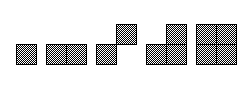

The area where pieces are placed is 6 units wide, and the maximum working height is 2. Some examples are:

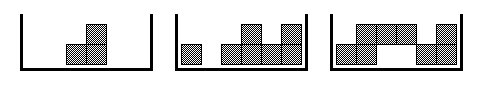

As in the regular game of tetris, rows are removed when they become full. The following picture (going left to right) shows how this happens when a piece is added:

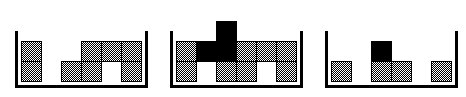


When the working height of 2 is exceeded, the bottom row is removed and the total height is incremented:

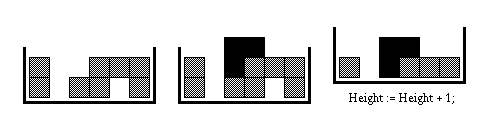

Note that a lower height indicates a better performance of the agent.

An example of a state that should have a low value is:

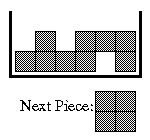

Given the next piece is a solid 2x2 block, the agent will be forced to increase the total height of the pile by 2 units. Therefore it is desirable to avoid getting into states like these.

Reference: This small version of the Tetris game and the rules are from https://melax.github.io/tetris/tetris.html


### Formulation

- *State* $s$: 
    
    The state $s$ contains two numbers, i.e., $s=(s_{\mathrm{gam}},s_{\mathrm{pie}})$. The number $s_{\mathrm{gam}}$ represents the game area, and the number $s_{\mathrm{pie}}$ represents the next piece. We use binary codes to encode the shape, where "1" means that there is a square in the correponding space, while "0" means that the space is empty. The 12 bits of the binary representation of $s_{\mathrm{gam}}$ encode the whole game area, where the lower 6 bits encode the lower layer of the game area and the higher 6 bits encode the higher layer. The 4 bits of the binary representation of $s_{\mathrm{pie}}$ encode the next piece, where the lower 2 bits encode the lower layer of the next piece and the higher 2 bits encode the higher layer. Take the following state as an example:
    
    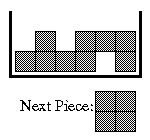
    
    In the above state, the binary representation of $s_{\mathrm{gam}}$ should be 010111 111101, whose decimal number is $1533$;
    the binary representation of $s_{\mathrm{pie}}$ should be 1111, whose decimal number is $15$. Hence, $s=(1533, 15)$.
    
    Note that two different $s_{\mathrm{pie}}$ could have the same shape after rotation. For example, there are four possible $s_{\mathrm{pie}}$ that can represent a single-square piece, i.e., the binary number 0001, 0010, 1000, or 0100. 


- *Action $a$*:
    
    The action $a$ also contains two numbers, i.e., $a=(a_{\mathrm{pos}},a_{\mathrm{rot}})$. The number $a_{\mathrm{pos}}\in\{0,1,2,3,4\}$ represents the position you want to put the next piece down, counting from right to left. The number $a_{\mathrm{rot}}\in\{0,1,2,3\}$ represents the clockwise rotation of the next piece. $0$ means no rotation.
    
    Note: Taking the same action on different representations $s_{\mathrm{pie}}$ of the same shape could have different results. For example, $s_{\mathrm{pie}}=0001$ is different from $s_{\mathrm{pie}}=0010$ when taking the action $a=(0, 0)$. For $s_{\mathrm{pie}}=0001$, $a_{\mathrm{pos}}=0$ means that the single-sqaure piece will drop down at the rightmost position, but for $s_{\mathrm{pie}}=0010$, $a_{\mathrm{pos}}=0$ means that the single-sqaure piece will drop down one space left.
    

- *Reward $r(s,a)$*:
    
    If the working height of 2 is exceeded by one, i.e., the total height is incremented by one, then a reward $-1$ occurs;
    
    If the working height of 2 is exceeded by two, i.e., the total height is incremented by two, then a reward $-2$ occurs.
    

- *Objective*: Maximize the expected total discounted reward:

    $$\mathbb{E} \left[\sum_{t=0}^{\infty} \gamma^t r(s_t,a_t)\right]$$
    
    where $\gamma=0.9$ denotes the discount factor.


In [1]:
# Upload the file "tetris_env.py"
try:
    from google.colab import files
    uploaded = files.upload()
except ImportError as e:
    pass

In [3]:
# Import packages. Run this cell.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from tetris_env import TetrisEnv
env = TetrisEnv(seed=0)

**(1).** SARSA with Linear Function Approximation (30 pts)

In this part, we will use SARSA with linear function approximation to play the Tetris game.

Please complete your agent (the python class `LFAAgent`) to implement the SARSA with linear function approximation algorithm.

**Note**:

This class will be initialized at the beginning of the test code.

The function `select_action` in the class will be called each step in the test code and returns an action for the agent to take.
The input `state_game` and `state_piece` are $s_{\mathrm{gam}}$ and $s_{\mathrm{pie}}$ defined in the **Formulation** part, respectively; 
The output `action_pos` and `action_rot` are $a_{\mathrm{pos}}$ and $a_{\mathrm{rot}}$ defined in the **Formulation** part, respectively.

The function `train` in the class will be called each step after the agent takes an action, receives a reward, and observes the next state. It is used for the update of the weights.
- The input `pre_state_game` and `pre_state_piece` is the state in the previous step.
- The input `pre_action_pos` and `pre_action_rot` is the action in the previous step.
- The input `pre_reward` is the reward received in the previous step.
- The input `cur_state_game` and `cur_state_piece` is the current state.
- The input `cur_action_pos` and `cur_action_rot` is the action that the agent takes in the current step.
- The input `done=0` means that the current episode does not terminate, and `done=1` means that the current episode terminates. We set the length of each episode to be 100.

You can define any function in the class if you need, such as a function that implements $\phi(s,a)$. You may also use the `rotate` function given in the class.


In [16]:
class LFAAgent:

    def __init__(self, seed):
        """
        initialize the coefficients theta and set hyper-parameters.
        """
        # The following are recommended hyper-parameters.

        # Initial learning rate: 0.01
        # Learning rate decay for each episode: 0.995
        # Minimum learning rate: 0.001
        # Initial epsilon for exploration: 0.5
        # Epsilon decay for each episode: 0.98

        self.gamma = 0.9  # Discount factor
        self.theta = np.zeros((640,))  # The weight vector to be learned
        self.learning_rate = 0.01  # Learning rate.
        self.learning_rate_decay = 0.995  # You may decay the learning rate as the training proceeds.
        self.min_learning_rate = 0.001
        self.epsilon = 0.5  # For the epsilon-greedy exploration.
        self.epsilon_decay = 0.98  # You may decay the epsilon as the training proceeds.
        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)
        
    def select_action(self, state_game, state_piece):
        """
        This function returns an action for the agent to take.
        Args:
            state_game: s_{gam}, the state of the game area in the current step
            state_piece: s_{pie}, the state of the next piece in the current step
        Returns:
            action_pos: a_{pos}, the position where the agent will put the next piece down
            action_rot: a_{rot}, clockwise rotation of the piece before putting the piece down
        """
        
        # Please complete codes for choosing an action given the current state  
        """
        Hint: You may use epsilon-greedy for exploration. 
        With probability self.epsilon, choose an action uniformly at random;
        Otherwise, choose a greedy action based on the approximated Q values.
        Recall that the Q values are aprroximated by the inner product of the weight vector (self.theta) and the feature vector (self.phi). 
        """
        ### BEGIN SOLUTION
        # YOUR CODE HERE
        if self.rng.random()<self.epsilon:
            action_pos=self.rng.choice([0,1,2,3,4])
            action_rot=self.rng.choice([0,1,2,3])
        else:
            q_fun=[]
            actions=[(a_pos,a_rot) for a_pos in range(5) for a_rot in range(4)]
            for action_pos, action_rot in actions:
                phifun=self.phi(state_game, state_piece, action_pos, action_rot)
                q_fun.append(np.dot(self.theta,phifun))
                best_index=np.argmax(q_fun)
                action_pos, action_rot=actions[best_index]
        return action_pos, action_rot
        # raise NotImplementedError()
        ### END SOLUTION
        return action_pos, action_rot
    
    def train(self, pre_state_game, pre_state_piece, pre_action_pos, pre_action_rot, pre_reward,
              cur_state_game, cur_state_piece, cur_action_pos, cur_action_rot, done):
        """
        This function is used for the update of the Q table
        Args:
            - pre_state_game: the state of the game area in the previous step
            - pre_state_piece: the state of the next piece in the previous step
            - pre_action_pos: the position where the agent puts the next piece down in the previous step
            - pre_action_rot: clockwise rotation of the piece before putting the piece down in the previous step
            - pre_reward: the reward received in the previous step.
            - cur_state_game: the state of the game area in the current step
            - cur_state_piece: the state of the next piece in the current step
            - cur_action_pos: the position where the agent puts the next piece down in the current step
            - cur_action_rot: clockwise rotation of the piece before putting the piece down in the current step
            - `done=0` means that the current episode does not terminate;
              `done=1` means that the current episode terminates.
              We set the length of each episode to be 100.
        """
        
        # Please complete codes for updating the weight vector self.theta
        """
        Hint: You may use the feature function self.phi
              You may use the discount factor self.gamma (=0.9)
        """
        ### BEGIN SOLUTION
        # YOUR CODE HERE
        cur_a_pos, cur_a_rot = self.select_action(cur_state_game,cur_state_piece)
        pre_phi=self.phi(pre_state_game, pre_state_piece, pre_action_pos, pre_action_rot)
        cur_phi=self.phi(cur_state_game, cur_state_piece, cur_a_pos, cur_a_rot)
        qfun_current=np.dot(self.theta, pre_phi)
        # if done!=0:
        qfun_next=np.dot(self.theta,cur_phi) 
        #else:
        #    qfun_next=0
        td_target=pre_reward + self.gamma* qfun_next
        td_error= td_target - qfun_current
        self.theta = self.theta + self.learning_rate* td_error * pre_phi

        # raise NotImplementedError()
        ### END SOLUTION
        
        if done != 0:
            self.learning_rate = self.learning_rate * self.learning_rate_decay
            if self.learning_rate < self.min_learning_rate:
                self.learning_rate = self.min_learning_rate
            self.epsilon = self.epsilon * self.epsilon_decay
    
    @staticmethod
    def rotate(p, action_rot):
        """
        Rotate the piece `p` clockwise.
        Args:
            - p: the piece
            - action_rot: clockwise rotation of the piece. 
                          action_rot = 0, 1, 2, or 3.
                          0 means no rotation.
        Returns:
            - a new piece after the rotation
        """
        while action_rot > 0:
            q = p >> 2
            p = (2 if p & 1 != 0 else 0) + (2 << 2 if p & 2 != 0 else 0) + (
                1 << 2 if q & 2 != 0 else 0) + (1 if q & 1 != 0 else 0)
            action_rot = action_rot - 1
        if p % (1 << 2) == 0:
            p >>= 2
        return p
    
    # For your reference, the following function is an example of the feature vector \phi(s,a)
    # You can directly use this function as \phi(s,a), or you can design your own.
    def phi(self, state_game, state_piece, action_pos, action_rot):
        """
        Implement the feature function phi(s, a)
        Args:
            state_game: s_{gam}, the state of the game area in the current step
            state_piece: s_{pie}, the state of the next piece in the current step
            action_pos: a_{pos}, the position where the agent puts the next piece down in the current step
            action_rot: a_{rot}, clockwise rotation of the piece before putting the piece down in the current step
        Returns:
            feature_vec: feature vector
        """
        feature_vec = np.zeros((640,))
        feature_s_vec = np.zeros((8,))
        h_row = np.unpackbits(np.array([state_game >> 6], dtype=np.uint8))
        l_row = np.unpackbits(np.array([state_game & 63], dtype=np.uint8))
        heights = h_row.astype(int) * 2 + (l_row - h_row == 1).astype(int)
        feature_s_vec[0] = np.max(heights)  # the height of the highest column
        feature_s_vec[1] = np.sum(h_row.astype(int) - l_row.astype(int) == 1)  # holes
        wells = 0
        for i in range(2, 8):
            if (i == 2 or heights[i] - heights[i - 1] < 0) and (i == 7 or heights[i + 1] - heights[i] > 0):
                wells += 1
        feature_s_vec[2] = wells  # wells

        for i in range(3, 8):
            feature_s_vec[i] = heights[i] - heights[i - 1]  # differences in height between neighboring columns

        piece_rotated = self.rotate(state_piece, action_rot)

        action = action_pos * 16 + piece_rotated
        feature_vec[action * 8:(action + 1) * 8] = feature_s_vec

        return feature_vec
    
    # You can use this function to visualize the game
    @staticmethod
    def visualize(env, action_rot, action_pos):
        """
        Visualize the game
        Args:
            env: Tetris environment object
            action_rot: a_{rot}, clockwise rotation of the piece before putting the piece down in the current step
            action_pos: a_{pos}, the position where the agent puts the next piece down in the current step
        """

        # borderlines of the plot
        xmin = 0
        xmax = 6
        ymin = 0
        ymax = 6
        
        # start plotting the game
        state_game, _ = env.get_state()
        
        upper_row = bin(state_game >> 6)
        upper_row = upper_row[2:].zfill(6)

        lower_row = bin(state_game & 63)
        lower_row = lower_row[2:].zfill(6)

        fig, ax = plt.subplots()

        y_lower_left_corner = 0
        x_lower_left_corner = 0

        for i in range(6):
            s = lower_row[i]
            if s == '1':
                ax.add_patch(Rectangle((x_lower_left_corner, y_lower_left_corner), 1, 1,color="black"))
            x_lower_left_corner +=1

        y_lower_left_corner += 1
        x_lower_left_corner = 0
        for i in range(6):
            s = upper_row[i]
            if s == '1':
                ax.add_patch(Rectangle((x_lower_left_corner, y_lower_left_corner), 1, 1,color="black"))
            x_lower_left_corner +=1

        # start plotting the piece    
        y_lower_left_corner += 1
        state_piece = env.rotate(env.piece,action_rot) << action_pos

        upper_row_piece = bin(state_piece >> 6)
        upper_row_piece = upper_row_piece [2:].zfill(6)

        lower_row_piece = bin(state_piece & 63)
        lower_row_piece = lower_row_piece [2:].zfill(6)

    
        x_lower_left_corner = 0
        for i in range(6):
            s = lower_row_piece[i]
            if s == '1':
                ax.add_patch(Rectangle((x_lower_left_corner, y_lower_left_corner), 1, 1,color="red"))
            x_lower_left_corner +=1

        x_lower_left_corner = 0
        y_lower_left_corner += 1

        for i in range(6):
            s = upper_row_piece[i]
            if s == '1':
                ax.add_patch(Rectangle((x_lower_left_corner, y_lower_left_corner), 1, 1,color="red"))
            x_lower_left_corner +=1


        ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
        plt.xlabel("X - position")
        plt.ylabel("Height")
        plt.title("Tetris Grid")
        plt.grid()
        black_patch = mpatches.Patch(color='black', label='Game Area')
        red_patch = mpatches.Patch(color='red', label='Rotated Piece')
        plt.legend(handles=[red_patch, black_patch])
        plt.show()

        

Your actions during the last episode:
step 1: 
state of the game area:
000000
000000
next piece:
01
11
actions:
position= 0 rotation= 0


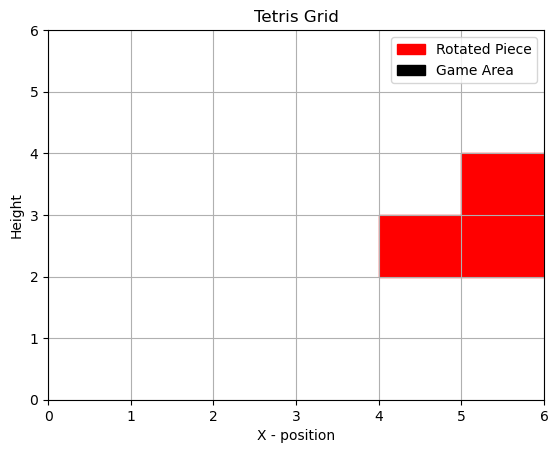

step 2: 
state of the game area:
000001
000011
next piece:
00
10
actions:
position= 2 rotation= 2


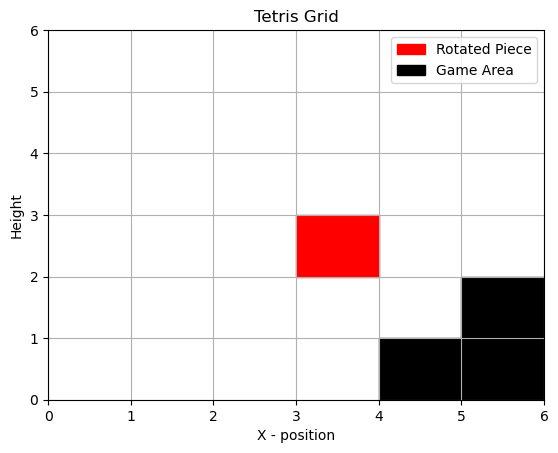

step 3: 
state of the game area:
000001
000111
next piece:
01
11
actions:
position= 4 rotation= 1


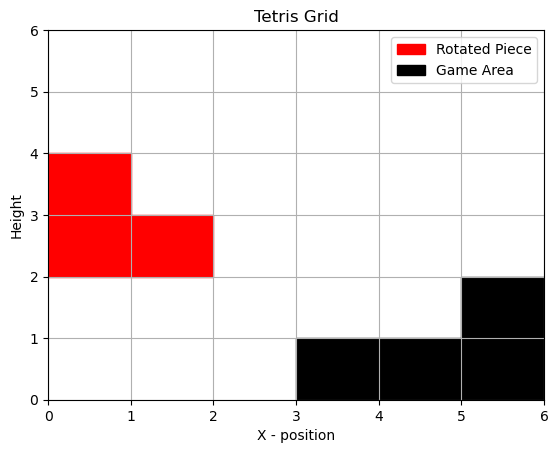

step 4: 
state of the game area:
100001
110111
next piece:
10
10
actions:
position= 3 rotation= 2


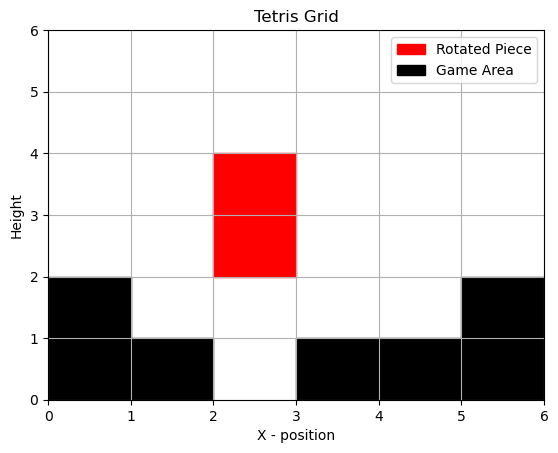

step 5: 
state of the game area:
000000
101001
next piece:
10
11
actions:
position= 2 rotation= 2


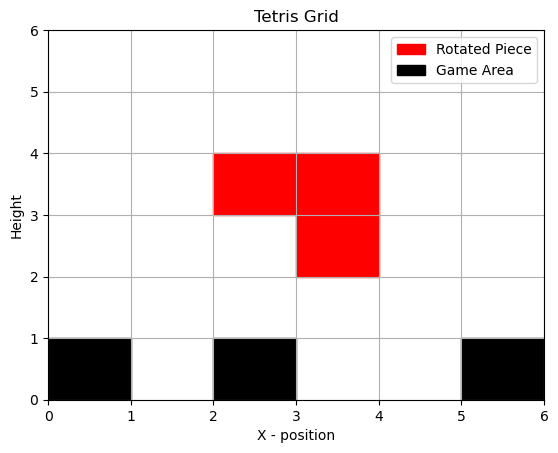

step 6: 
state of the game area:
001100
101101
next piece:
00
11
actions:
position= 4 rotation= 0


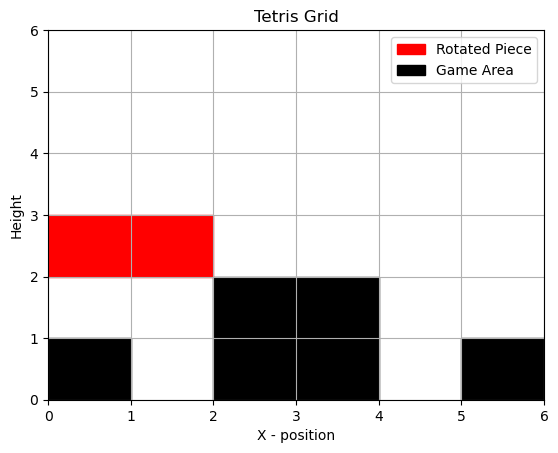

step 7: 
state of the game area:
111100
101101
next piece:
00
01
actions:
position= 1 rotation= 0


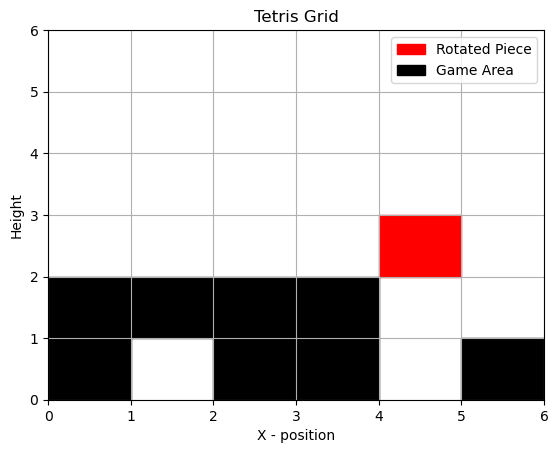

step 8: 
state of the game area:
111100
101111
next piece:
01
11
actions:
position= 0 rotation= 2


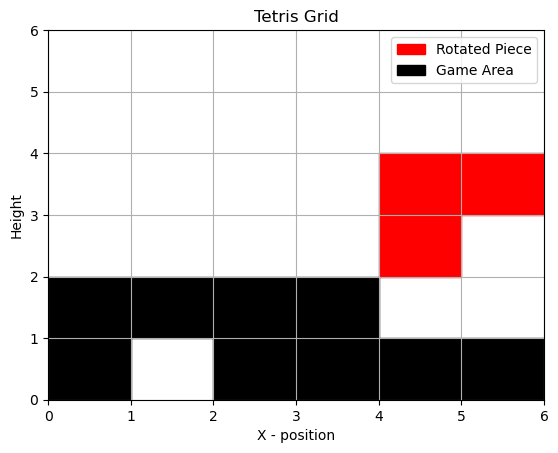

step 9: 
state of the game area:
000011
111110
next piece:
11
10
actions:
position= 4 rotation= 3


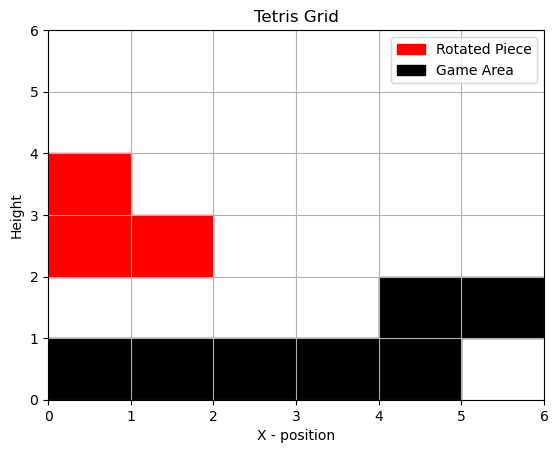

step 10: 
state of the game area:
100000
110011
next piece:
01
10
actions:
position= 2 rotation= 0


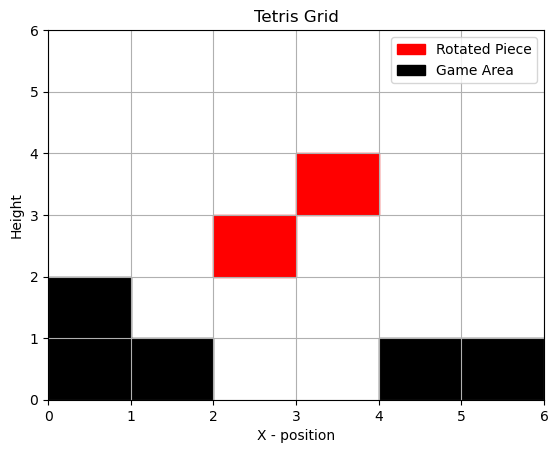


Your total reward averaged over the last 100 episodes:
-12.800


In [17]:
# The code in this cell is provided for debugging and is also a sample test.
# The following code will train and run your agent in the Teris environment for 500 episodes.
# The length of each episode is set to be 100.
# We will print your agent's first 10 actions during the last episode and the total reward averaged over the last 100 episodes.
# You can check whether your policy is good by this information.
np.random.seed(0)
agent = LFAAgent(seed=0)
print("Your actions during the last episode:")
total_reward = 0.0
num_ep = 500

for ep in range(num_ep):
    state_game, state_piece = env.reset()
    pre_state_game = None
    pre_state_piece = None
    pre_action_pos = None
    pre_action_rot = None
    pre_reward = None
    for step in range(100):
        action_pos, action_rot = agent.select_action(state_game, state_piece)
        
        if ep == num_ep - 1 and step < 10:
            print('step %d: ' % (step + 1))
            print('state of the game area:')
            print(format(state_game >> 6, 'b').zfill(6))
            print(format(state_game & 63, 'b').zfill(6))
            print('next piece:')
            print(format(state_piece >> 2, 'b').zfill(2))
            print(format(state_piece & 3, 'b').zfill(2))
            print('actions:')
            print('position=', action_pos, 'rotation=', action_rot)
            agent.visualize(env, action_rot, action_pos)
        
        next_state_game, next_state_piece, reward = env.step(action_pos, action_rot)

        if 1 <= step < 99:
            agent.train(pre_state_game, pre_state_piece, pre_action_pos, pre_action_rot, pre_reward,
                        state_game, state_piece, action_pos, action_rot, 0)
        elif step == 99:
            agent.train(pre_state_game, pre_state_piece, pre_action_pos, pre_action_rot, pre_reward,
                        state_game, state_piece, action_pos, action_rot, 1)

        if num_ep - ep <= 100:
            total_reward = total_reward + reward

        pre_state_game = state_game
        pre_state_piece = state_piece
        pre_action_pos = action_pos
        pre_action_rot = action_rot
        pre_reward = reward
        state_game = next_state_game
        state_piece = next_state_piece

total_reward = total_reward / 100
print("")
print("Your total reward averaged over the last %d episodes:\n%.3f" % (100, total_reward))

# Sample test
# Check if the total reward is larger than -15
assert total_reward >= -15, "Sample test, average total reward is less than -15."